# Snakes and Ladders

In [1]:
import sys
sys.path.append('../')

from dataclasses import dataclass
from typing import Mapping, Dict
from rl.distribution import Categorical
from rl.markov_process import Transition, FiniteMarkovProcess

import numpy as np
import seaborn as sns

In [2]:
@dataclass(frozen=True)
class BoardPositionState:
    # check that at most one of the above is true
    state_num: int
    
    
class SnakesLaddersMPFinite(FiniteMarkovProcess[BoardPositionState]):
    
    def __init__(
        self,
        snake_ladder_states,
    ):
        self.snl_states: Mapping[int, int] = snake_ladder_states
        self.near_end_states: set() = {95, 96, 97, 99}
        
        super().__init__(self.get_transition_map())
    
    def endprobs(self, state_num) -> Mapping[BoardPositionState, float]:
        """Convert from a state near the end to a transition probability"""
        state_probs_map: Mapping[BoardPositionState, float] = {}
        probs_map: Mapping[int, float] = {}
            
        for k in range(1,7):
            if k <= (100 - state_num):
                nextstate = state_num + k
                if nextstate not in probs_map:
                    probs_map[nextstate] = 1.0/6.0
                else:
                    probs_map[nextstate] += 1.0/6.0
            else:
                nextstate = 100 - (state_num + k - 100)
                if nextstate not in probs_map:
                    probs_map[nextstate] = 1.0/6.0
                else:
                    probs_map[nextstate] += 1.0/6.0
        print(state_num, probs_map)
        for state in probs_map.keys():
            state_probs_map[BoardPositionState(state)] = probs_map[state]
            
        return state_probs_map
    
    def get_transition_map(self) -> Transition[BoardPositionState]:
        d: Dict[BoardPositionState, Categorical[BoardPositionState]] = {}
        
        # iterate over the normal states to construct their probabilities
        for statenum in range(1, 100):
            snl = statenum in self.snl_states
            near_end = statenum in self.near_end_states
            state = BoardPositionState(statenum)
                
            # is this a special state?
            if snl:
                realstatenum = self.snl_states[statenum]
            else:
                realstatenum = statenum
            
            # is this a normal state?
            if not near_end:
                # use real state number to determine probs
                state_probs_map: Mapping[BoardPositionState, float] = {
                    BoardPositionState(realstatenum + k): 1.0/6.0 for k in range(1,7)
                }
            else:
                state_probs_map: Mapping[BoardPositionState, float] = \
                    self.endprobs(realstatenum)
            d[BoardPositionState(statenum)] = Categorical(state_probs_map)
        
        # Winning Absorbing State
        d[BoardPositionState(100)] = Categorical({BoardPositionState(100): 1.0})
        return d            

In [3]:
snl_states = {98: 54, 94: 42, 82: 63, 88: 50, 76: 37, 70:34, 65:14, 53:17, 49: 8, 38:1,
              3: 39, 7:48, 12:51, 20:41, 25:57, 28:35, 45:74, 60:85, 67:90, 69:92}
snl_mp = SnakesLaddersMPFinite(snl_states)

# print("Transition Map")
# print("--------------")
# print(snl_mp)

# print("Stationary Distribution")
# print("-----------------------")

# should be 1.0 in state 100 because it is an absorbing MarkovChain
snl_mp.display_stationary_distribution()

# Starting Distribution
start_dist_map: Mapping[BoardPositionState, float] = {
                    BoardPositionState(k): 1.0/6.0 for k in range(1,7)
                }
start_dist = Categorical(start_dist_map)

95 {96: 0.16666666666666666, 97: 0.16666666666666666, 98: 0.16666666666666666, 99: 0.3333333333333333, 100: 0.16666666666666666}
96 {97: 0.16666666666666666, 98: 0.3333333333333333, 99: 0.3333333333333333, 100: 0.16666666666666666}
97 {98: 0.3333333333333333, 99: 0.3333333333333333, 100: 0.16666666666666666, 97: 0.16666666666666666}
99 {100: 0.16666666666666666, 99: 0.16666666666666666, 98: 0.16666666666666666, 97: 0.16666666666666666, 96: 0.16666666666666666, 95: 0.16666666666666666}
{BoardPositionState(state_num=31): 0.0,
 BoardPositionState(state_num=30): 0.0,
 BoardPositionState(state_num=2): 0.0,
 BoardPositionState(state_num=1): 0.0,
 BoardPositionState(state_num=3): 0.0,
 BoardPositionState(state_num=5): 0.0,
 BoardPositionState(state_num=4): 0.0,
 BoardPositionState(state_num=6): 0.0,
 BoardPositionState(state_num=7): 0.0,
 BoardPositionState(state_num=8): 0.0,
 BoardPositionState(state_num=9): 0.0,
 BoardPositionState(state_num=10): 0.0,
 BoardPositionState(state_num=11): 0.0,

In [4]:
# simple path tracing example
tracer = snl_mp.traces(start_dist)
path = []
sim = next(tracer)
nextstate = BoardPositionState(0)
while nextstate.state_num != 100:
    nextstate = next(sim)
    print(nextstate)
    path.append(next(sim))

BoardPositionState(state_num=3)
BoardPositionState(state_num=45)
BoardPositionState(state_num=80)
BoardPositionState(state_num=91)
BoardPositionState(state_num=95)
BoardPositionState(state_num=98)
BoardPositionState(state_num=87)
BoardPositionState(state_num=96)
BoardPositionState(state_num=99)
BoardPositionState(state_num=99)
BoardPositionState(state_num=98)
BoardPositionState(state_num=91)
BoardPositionState(state_num=99)
BoardPositionState(state_num=100)


In [5]:
# creating a prob dist of finishing steps
pathlengths = []
tracer = snl_mp.traces(start_dist)

for i in range(1000):
    pathlen = 0
    sim = next(tracer)
    nextstate = BoardPositionState(0)
    while nextstate.state_num != 100:
        nextstate = next(sim)
        pathlen += 1
    pathlengths.append(pathlen)

/Users/bodhinguyen/Code/RL-book/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


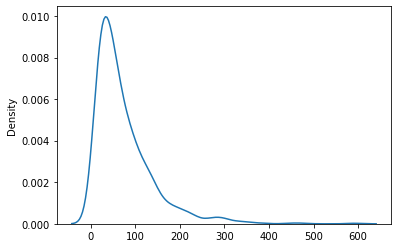

In [6]:
# Distribution of finishing times
sns.distplot(pathlengths, hist = False, kde = True)

In [7]:
# average finishing time and median
print(np.mean(pathlengths))
print(np.median(pathlengths))

74.303
55.0
